In [1]:
from distributed import Client
client = Client()

In [44]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import datetime as dt
import tabula as tb
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols
import scipy.stats as sp
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import decomposition
from functions import *

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

<p>Nutriscore variables nécessaires :
<ul>
    <li>Energy density (kJ/100g)</li>
    <li>Sugars (g/100g)</li>
    <li>Saturated fatty acids (g/100g)</li>
    <li>Sodium (mg/100g)</li>
    <li>Fruits,vegetables,pulses, nuts, and rapeseed, walnut and olive oils (%)</li>
    <li>Fibre (g/100g)</li>
    <li>Protein (g/100g)</li>
    <li>Ratio total saturated fatty acids/lipids (%)</li>
</ul></p>

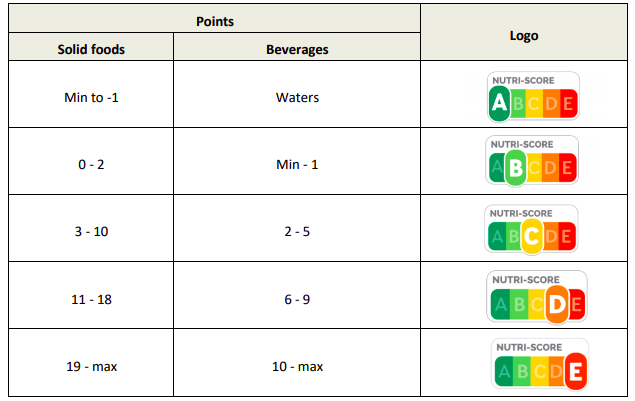

In [3]:
minus_point = tb.read_pdf("data/Nutriscore.pdf", pages='28', pandas_options={'header':1})
minus_point2 = tb.read_pdf("data/Nutriscore.pdf", pages='30', pandas_options={'header':1})

Got stderr: août 25, 2021 5:26:34 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
AVERTISSEMENT: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'
août 25, 2021 5:26:35 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
AVERTISSEMENT: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'

Got stderr: août 25, 2021 5:26:36 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
AVERTISSEMENT: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'
août 25, 2021 5:26:36 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
AVERTISSEMENT: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'



In [4]:
minus_point = minus_point[0]
minus_point = minus_point.drop(0)
minus_point = minus_point.drop(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', '1'], axis = 1)
minus_point = minus_point.rename(columns={"fatty acids (g/100g)":"Saturated fatty acids (g/100g)"})
minus_point = minus_point.reset_index(drop=True)

In [5]:
minus_point2 = minus_point2[0]
minus_point2 = minus_point2.rename(columns={"total saturated fatty acids/lipids":
                                            "Total saturated fatty acids/lipids Ratio (%)"})
minus_point2 = minus_point2.drop([0, 1])
minus_point2 = minus_point2.reset_index(drop = True)

In [6]:
minus_point = pd.concat([minus_point, minus_point2.iloc[:,1]], axis = 1)
minus_point = minus_point.drop("Saturated fatty acids (g/100g)", axis = 1)
minus_point.iloc[:, 1:] = minus_point.iloc[:, 1:].applymap(lambda x: x[1:])
minus_point.iloc[:, 1:] = minus_point.iloc[:, 1:].astype(float)
minus_point.iloc[:, 0] = minus_point.iloc[:, 0].astype(int)

del minus_point2

In [7]:
minus_point.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 5 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Points                                        11 non-null     int64  
 1   Energy density (kJ/100g)                      11 non-null     float64
 2   Sugars (g/100g)                               11 non-null     float64
 3   Sodium (mg/100g)                              11 non-null     float64
 4   Total saturated fatty acids/lipids Ratio (%)  11 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 568.0 bytes


In [8]:
plus_point = tb.read_pdf("data/Nutriscore.pdf", pages='29', pandas_options={'header':1})

Got stderr: août 25, 2021 5:26:37 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
AVERTISSEMENT: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'
août 25, 2021 5:26:37 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
AVERTISSEMENT: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'



In [9]:
plus_point = plus_point[0]
plus_point.columns = ["Points", "Fruits, vegetables, pulses, nuts, and rapeseed,\
 walnut and olive oils (%)", "Fibre (g/100g)", "Protein (g/100g)"]
plus_point = plus_point.drop([0,1,2,3,4,5,6])
plus_point = plus_point.reset_index(drop=True)
plus_point.iloc[:, 1:] = plus_point.iloc[:, 1:].applymap(lambda x: x[1:])
plus_point.iloc[:,1] = plus_point.iloc[:,1].replace("",60)
plus_point.iloc[:, 0] = plus_point.iloc[:, 0].astype(int)
plus_point.iloc[:, 1:] = plus_point.iloc[:, 1:].astype(float)

plus_point.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Points                                                                     6 non-null      int64  
 1   Fruits, vegetables, pulses, nuts, and rapeseed, walnut and olive oils (%)  6 non-null      float64
 2   Fibre (g/100g)                                                             6 non-null      float64
 3   Protein (g/100g)                                                           6 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 320.0 bytes


In [10]:
dtype_error = {'additives_en': 'str',
       'additives_tags': 'str',
       'brand_owner': 'str',
       'cities_tags': 'str',
       'code': 'str',
       'emb_codes': 'str',
       'emb_codes_tags': 'str',
       'first_packaging_code_geo': 'str',
       'generic_name': 'str',
       'ingredients_from_palm_oil_tags': 'str',
       'ingredients_that_may_be_from_palm_oil_tags': 'str',
       'manufacturing_places': 'str',
       'manufacturing_places_tags': 'str',
       'origins': 'str',
       'origins_en': 'str',
       'origins_tags': 'str',
       'packaging': 'str',
       'packaging_tags': 'str',
       'packaging_text': 'str',
       'purchase_places': 'str',
       'serving_size': 'str',
       'traces': 'str',
        'abbreviated_product_name':'str'}

In [11]:
keep_col = ['code',
 'url',
 'creator',
 'last_modified_datetime',
 'product_name',
 'abbreviated_product_name',
 'generic_name',
 'quantity',
 'brands',
 'brands_tags',
 'categories_en',
 'countries_en',
 'labels',
 'emb_codes',
 'emb_codes_tags',
 'ingredients_text',
 'allergens',
 'traces',
 'serving_size',
 'serving_quantity',
 'additives_n',
 'additives_en',
 'ecoscore_score_fr',
 'ecoscore_grade_fr',
 'main_category_en',
 'nutriscore_score',
 'nutriscore_grade',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'sugars_100g',
 'fiber_100g',
 'carbohydrates_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-dried_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g']

In [12]:
raw_data = dd.read_csv("data/foodfacts.csv", sep = "\t", engine="python", doublequote=False, dtype=dtype_error, usecols=keep_col)

In [13]:
raw_data.columns.to_list()

['code',
 'url',
 'creator',
 'last_modified_datetime',
 'product_name',
 'abbreviated_product_name',
 'generic_name',
 'quantity',
 'brands',
 'brands_tags',
 'categories_en',
 'labels',
 'emb_codes',
 'emb_codes_tags',
 'countries_en',
 'ingredients_text',
 'allergens',
 'traces',
 'serving_size',
 'serving_quantity',
 'additives_n',
 'additives_en',
 'nutriscore_score',
 'nutriscore_grade',
 'ecoscore_score_fr',
 'ecoscore_grade_fr',
 'main_category_en',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-dried_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g']

In [14]:
len(raw_data)

1919562

In [15]:
raw_data = raw_data[raw_data["countries_en"]=="France"].compute()
raw_data = raw_data.reset_index()

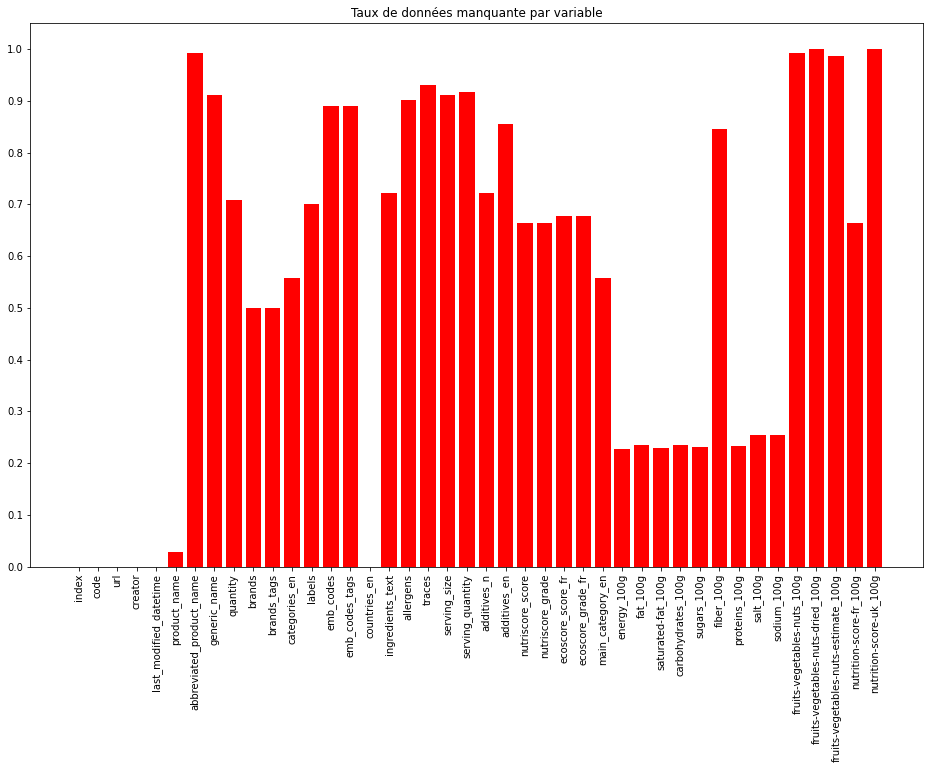

In [16]:
temp_NA_raw = raw_data.isna().mean()

fig, ax = plt.subplots(figsize=(16, 10))
ax.bar(x= temp_NA_raw.index, height =  temp_NA_raw.values, color = "red")
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.05, 0.1))
plt.title("Taux de données manquante par variable")
plt.show()

In [17]:
raw_data.shape

(756204, 42)

In [18]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756204 entries, 0 to 756203
Data columns (total 42 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   index                                 756204 non-null  int64  
 1   code                                  756204 non-null  object 
 2   url                                   756204 non-null  object 
 3   creator                               756203 non-null  object 
 4   last_modified_datetime                756204 non-null  object 
 5   product_name                          734054 non-null  object 
 6   abbreviated_product_name              6259 non-null    object 
 7   generic_name                          66513 non-null   object 
 8   quantity                              220545 non-null  object 
 9   brands                                377706 non-null  object 
 10  brands_tags                           377670 non-null  object 
 11  

In [19]:
raw_data["last_modified_datetime"] = pd.to_datetime(raw_data["last_modified_datetime"])

In [20]:
raw_data.shape

(756204, 42)

In [21]:
mask = raw_data.duplicated(subset="code", keep=False)
doublon = raw_data[mask]

In [22]:
doublon

,index,code,url,creator,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,brands,brands_tags,categories_en,labels,emb_codes,emb_codes_tags,countries_en,ingredients_text,allergens,traces,serving_size,serving_quantity,additives_n,additives_en,nutriscore_score,nutriscore_grade,ecoscore_score_fr,ecoscore_grade_fr,main_category_en,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
172133,8578,30383354190402,http://world-en.openfoodfacts.org/product/3038...,openfoodfacts-contributors,2021-01-15 09:21:20+00:00,basilic,NaN,NaN,210 g,panzani,panzani,"Groceries,Sauces,Tomato sauces","Nutriscore,Nutriscore A",NaN,NaN,France,Pulpe de tomates fraîches avec morceaux et pur...,NaN,NaN,NaN,NaN,1.0,E14XX - Modified Starch,2.0,b,NaN,NaN,Tomato sauces,261.0,3.00,0.30,6.100000,5.50,2.2,1.700000,0.99,0.396,NaN,NaN,NaN,2.0,NaN
172134,8579,30383354190402,http://world-en.openfoodfacts.org/product/3038...,openfoodfacts-contributors,2021-01-15 09:23:03+00:00,basilic,NaN,NaN,210 g,panzani,panzani,"Groceries,Sauces,Tomato sauces","Nutriscore, Nutriscore A",NaN,NaN,France,Pulpe de tomates fraîches avec morceaux et pur...,NaN,NaN,NaN,NaN,1.0,E14XX - Modified Starch,-3.0,a,84.0,a,Tomato sauces,261.0,3.00,0.30,6.100000,5.50,2.2,1.700000,0.99,0.396,NaN,NaN,92.0,-3.0,NaN
402476,27183,3560070278831,http://world-en.openfoodfacts.org/product/3560...,openfoodfacts-contributors,2021-04-17 07:44:17+00:00,"Pamplemousse rose, 100 % Pur Fruit Pressé",NaN,"Jus de pamplemousse rose - Pamplemousse Rose, ...",1 L e,"Carrefour,CMI (Carrefour Marchandises Internat...","carrefour,cmi-carrefour-marchandises-internati...","Pure-grapefruit-juice,Beverages,Fruit-based be...","en:distributor-labels,en:carrefour-quality,en:...","EMB 36229,EMB 45273,EMB 67434,emb-36229m","emb-36229,emb-45273,emb-67434,emb-36229m",France,"Jus de pamplemousse rose, pulpe (2%).",NaN,NaN,200ml,200.0,0.0,NaN,2.0,c,NaN,NaN,Squeezed juices,151.0,0.00,0.00,8.500000,8.50,NaN,0.000000,0.00,0.000,100.0,NaN,NaN,2.0,NaN
402477,27184,3560070278831,http://world-en.openfoodfacts.org/product/3560...,openfoodfacts-contributors,2021-05-21 06:06:39+00:00,"Pamplemousse rose, 100 % Pur Fruit Pressé",NaN,"Jus de pamplemousse rose - Pamplemousse Rose, ...",1 L e,"Carrefour,CMI (Carrefour Marchandises Internat...","carrefour,cmi-carrefour-marchandises-internati...","Plant-based foods and beverages,Beverages,Plan...","Labels de distributeurs, Qualité Carrefour, Po...","EMB 36229,EMB 45273,EMB 67434,emb-36229m","emb-36229,emb-45273,emb-67434,emb-36229m",France,"Jus de pamplemousse rose, pulpe (2%).",NaN,NaN,200ml,200.0,0.0,NaN,2.0,c,35.0,d,Pure-grapefruit-juice,151.0,0.00,0.00,8.500000,8.50,NaN,0.000000,0.00,0.000,100.0,NaN,NaN,2.0,NaN
546798,18798,3770008983205,http://world-en.openfoodfacts.org/product/3770...,r-x,2021-02-25 08:40:12+00:00,REMYX VODKA Aquatique,NaN,Vodka,70 cl,REMYX VODKA,remyx-vodka,"Beverages,Alcoholic beverages,Hard liquors,Eau...",NaN,NaN,NaN,France,"eau, blé de printemps, alcool",NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Vodka,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546799,18799,3770008983205,http://world-en.openfoodfacts.org/product/3770...,r-x,2021-02-25 08:40:12+00:00,REMYX VODKA Aquatique,NaN,Vodka,70 cl,REMYX VODKA,remyx-vodka,"Beverages,Alcoholic beverages,Hard liquors,Eau...",NaN,NaN,NaN,France,"eau, blé de printemps, alcool",NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,74.0,b,Vodka,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
646093,14096,6703501220017,http://world-en.openfoodfacts.org/product/6703...,kiliweb,2021-06-25 16:23:52+00:00,Farine T45,NaN,NaN,1 kg,Minoterie Burggraf-Becker,minoterie-burggraf-becker,"Plant-based foods and beverages,Plant-based fo...",NaN,NaN,NaN,France,Farine t45,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,115.0,a,Wheat flour 

In [23]:
del doublon, mask

raw_data = raw_data.sort_values("last_modified_datetime", ascending=False)\
    .drop_duplicates(subset="code", keep="first")

In [24]:
raw_data.shape

(756200, 42)

In [25]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756200 entries, 7811 to 218654
Data columns (total 42 columns):
 #   Column                                Non-Null Count   Dtype              
---  ------                                --------------   -----              
 0   index                                 756200 non-null  int64              
 1   code                                  756200 non-null  object             
 2   url                                   756200 non-null  object             
 3   creator                               756199 non-null  object             
 4   last_modified_datetime                756200 non-null  datetime64[ns, UTC]
 5   product_name                          734050 non-null  object             
 6   abbreviated_product_name              6259 non-null    object             
 7   generic_name                          66511 non-null   object             
 8   quantity                              220541 non-null  object             
 9   b

In [26]:
raw_data = raw_data.astype({"code":float, "url":str, "product_name":str,
                 "abbreviated_product_name":str})
raw_data.dtypes

index                                                 int64
code                                                float64
url                                                  object
creator                                              object
last_modified_datetime                  datetime64[ns, UTC]
product_name                                         object
abbreviated_product_name                             object
generic_name                                         object
quantity                                             object
brands                                               object
brands_tags                                          object
categories_en                                        object
labels                                               object
emb_codes                                            object
emb_codes_tags                                       object
countries_en                                         object
ingredients_text                        

In [27]:
raw_data.describe()

,index,code,serving_quantity,additives_n,nutriscore_score,ecoscore_score_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,756200.000000,7.562000e+05,62061.000000,209600.000000,254653.000000,243856.000000,5.843260e+05,578776.000000,582645.000000,578703.000000,581755.000000,116732.000000,580466.000000,563432.000000,563431.000000,5390.000000,283.000000,9437.000000,254657.000000,6.000000
mean,13859.923848,8.608811e+49,121.815100,1.594509,9.475989,43.220409,1.168717e+03,14.269256,5.428754,26.985480,13.607901,2.913979,9.149704,1.281172,0.512579,40.204645,15.176005,46.848921,9.476135,13.166667
std,8123.863522,7.486202e+52,798.490737,2.375537,8.724963,27.381615,1.060714e+04,41.965835,8.389778,253.864528,40.657084,5.027391,96.333760,19.388372,7.755666,35.925860,30.116265,28.413682,8.724984,9.282600
min,0.000000,2.000000e+00,0.000000,0.000000,-15.000000,-28.000000,0.000000e+00,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,1.000000
25%,6803.000000,3.055150e+12,30.000000,0.000000,2.000000,24.000000,4.690000e+02,1.000000,0.200000,2.300000,0.600000,0.100000,1.500000,0.060000,0.024000,5.830000,0.000000,19.000000,2.000000,5.500000
50%,13833.000000,3.450612e+12,90.000000,1.000000,10.000000,38.000000,1.088000e+03,8.000000,2.000000,13.500000,3.200000,1.600000,6.300000,0.550000,0.220000,33.000000,0.000000,50.000000,10.000000,15.500000
75%,20747.000000,4.002631e+12,145.000000,2.000000,16.000000,65.000000,1.669000e+03,22.130000,8.000000,51.000000,19.000000,3.500000,13.000000,1.310000,0.524000,66.000000,7.000000,64.000000,16.000000,21.000000
max,30868.000000,6.509983e+55,100000.000000,30.000000,40.000000,125.000000,8.010000e+06,29000.000000,2000.000000,192000.000000,27000.000000,100.000000,73000.000000,14000.000000,5600.000000,100.000000,100.000000,100.000000,40.000000,22.000000



<p>On peut remarquer ici plusieurs incohérences :
<ul>
    <li>energy_100g : Max supérieur à 10000 (valeur = 8010000)</li>
    <li>fat_100g : Max supérieur à 100g (valeur = 29000)</li>
    <li>saturated-fat_100g : Max supérieur à 100g (valeur = 2000)</li>
    <li>sugars_100g : Max supérieur à 100g (valeur = 27000) et min inférieur à 0 (valeur = -1)</li>
    <li>proteins_100g : Max supérieur à 100g (valeur = 73000)</li>
    <li>sodium_100g : Max supérieur à 100g (valeur = 73000)</li>
</ul></p>

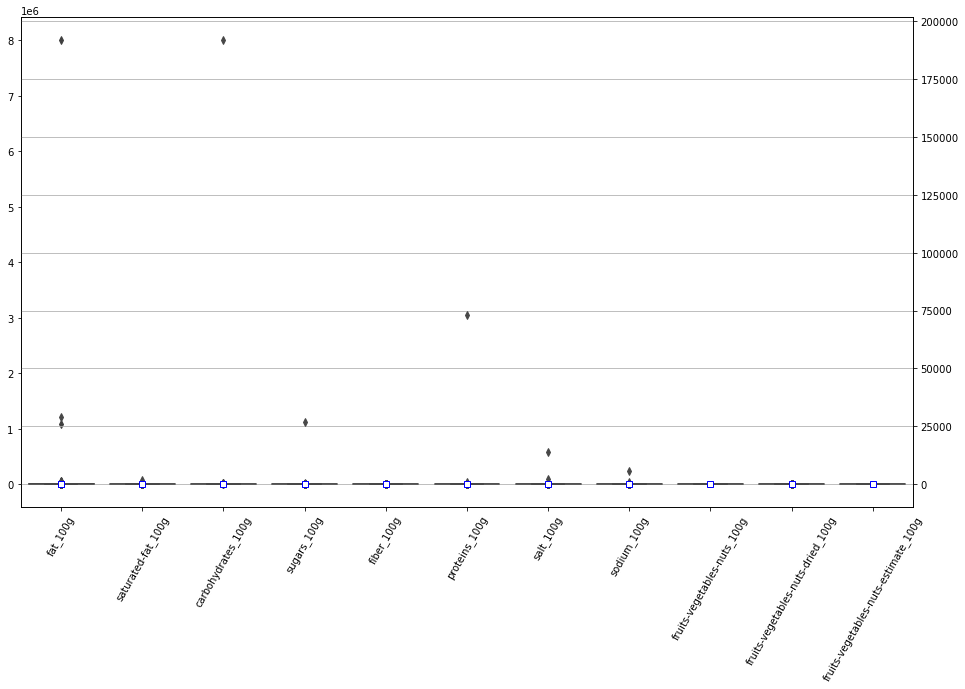

In [28]:
raw_data["aggregate_100g"] = raw_data['fat_100g'] + raw_data['carbohydrates_100g'] + raw_data['proteins_100g'] + raw_data['salt_100g']

temp = raw_data.iloc[:,28]
temp2 = raw_data.iloc[:,29:40]

f, ax = plt.subplots(figsize=(16,9))
plt.xticks(rotation = 60)
ax2 = ax.twinx()

sns.boxplot(data=temp, dodge=False, orient = 'v', showfliers = True, showmeans = True,\
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"}, ax=ax)

sns.boxplot(data=temp2, dodge=False, orient = 'v', showfliers = True, showmeans = True,\
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"}, ax=ax2)


plt.grid()
plt.draw()

In [29]:
check_error = {"energy_100g":np.array([raw_data[raw_data["energy_100g"] > 10000],
                                     raw_data[raw_data["energy_100g"] < 0]], dtype='object'),
              "fat_100g":np.array([raw_data[raw_data["fat_100g"] > 100],
                                     raw_data[raw_data["fat_100g"] < 0]], dtype='object'),
              "saturated-fat_100g":np.array([raw_data[raw_data["saturated-fat_100g"] > 100],
                                     raw_data[raw_data["saturated-fat_100g"] < 0]], dtype='object'),
              "carbohydrates_100g":np.array([raw_data[raw_data["carbohydrates_100g"] > 100],
                                     raw_data[raw_data["carbohydrates_100g"] < 0]], dtype='object'), 
              "sugars_100g":np.array([raw_data[raw_data["sugars_100g"] > 100],
                                     raw_data[raw_data["sugars_100g"] < 0]], dtype='object'),
              "proteins_100g":np.array([raw_data[raw_data["proteins_100g"] > 100],
                                     raw_data[raw_data["proteins_100g"] < 0]], dtype='object'),
              "salt_100g":np.array([raw_data[raw_data["salt_100g"] > 100],
                                     raw_data[raw_data["salt_100g"] < 0]], dtype='object'),
              "sodium_100g":np.array([raw_data[raw_data["sodium_100g"] > 100],
                                     raw_data[raw_data["sodium_100g"] < 0]], dtype='object'),
              "fruits-vegetables-nuts_100g":np.array([raw_data[raw_data["fruits-vegetables-nuts_100g"] > 100],
                                     raw_data[raw_data["fruits-vegetables-nuts_100g"] < 0]], dtype='object'),
              "fruits-vegetables-nuts-dried_100g":np.array([raw_data[raw_data["fruits-vegetables-nuts-dried_100g"] > 100],
                                     raw_data[raw_data["fruits-vegetables-nuts-dried_100g"] < 0]], dtype='object'),
              "fruits-vegetables-nuts-estimate_100g":np.array([raw_data[raw_data["fruits-vegetables-nuts-estimate_100g"] > 100],
                                     raw_data[raw_data["fruits-vegetables-nuts-estimate_100g"] < 0]], dtype='object')}

error_data = raw_data[(raw_data["energy_100g"] > 10000) | (raw_data["energy_100g"] < 0) | (raw_data["fat_100g"] > 100)\
            | (raw_data["fat_100g"] < 0) | (raw_data["saturated-fat_100g"] > 100) | (raw_data["saturated-fat_100g"] < 0)\
            | (raw_data["sugars_100g"] > 100) | (raw_data["sugars_100g"] < 0) | (raw_data["proteins_100g"] > 100)\
            | (raw_data["proteins_100g"] < 0) | (raw_data["salt_100g"] > 100) | (raw_data["salt_100g"] < 0) \
            | (raw_data["sodium_100g"] > 100) | (raw_data["sodium_100g"] < 0)\
            | (raw_data["fruits-vegetables-nuts-dried_100g"] > 100) | (raw_data["fruits-vegetables-nuts-dried_100g"] < 0)\
            | (raw_data["fruits-vegetables-nuts_100g"] > 100) | (raw_data["fruits-vegetables-nuts_100g"] < 0)\
            | (raw_data["fruits-vegetables-nuts-estimate_100g"] > 100) | (raw_data["fruits-vegetables-nuts-estimate_100g"] < 0)
            | (raw_data["carbohydrates_100g"] > 100) | (raw_data["carbohydrates_100g"] < 0)]

In [30]:

raw_data_noerror = raw_data.drop(error_data.index.to_list())

for key, value in check_error.items():
    for item in value:
        if item.size == 0:
            continue
        for label, row in item.iterrows():
            if key == "saturated-fat_100g" and raw_data.loc[label, key] > raw_data.loc[label, "fat_100g"]:
                raw_data.loc[label, "saturated-fat_100g"] = raw_data.loc[label, "fat_100g"]
            elif key == "sodium_100g" and raw_data.loc[label, key] > raw_data.loc[label, "salt_100g"]:
                raw_data.loc[label, "sodium_100g"] = raw_data.loc[label, "salt_100g"]
            elif key == "sugar_100g" and raw_data.loc[label, key] > raw_data.loc[label, "carbohydrates_100g"]:
                raw_data.loc[label, "sugar_100g"] = raw_data.loc[label, "carbohydrates_100g"]
            elif raw_data_noerror.loc[raw_data_noerror["categories_en"] == row["categories_en"], key].empty == True:
                raw_data.loc[label, key] = np.around(raw_data_noerror.loc[:, key].mean(), decimals=2)
            else:
                raw_data.loc[label, key] = np.around(raw_data_noerror.loc[raw_data_noerror["categories_en"] == row["categories_en"], key].mean(), decimals=2)

raw_data["aggregate_100g"] = raw_data['fat_100g'] + raw_data['carbohydrates_100g'] + raw_data['proteins_100g'] + raw_data['salt_100g']
del raw_data_noerror, check_error, error_data

In [31]:
l_aggre = ['fat_100g','carbohydrates_100g','proteins_100g','salt_100g']

for label, row  in raw_data[raw_data["aggregate_100g"]>100].iterrows():
    a = row["aggregate_100g"] - 100
    for i in l_aggre:
        raw_data.loc[label, i] = raw_data.loc[label, i] - np.around(a * (row[i]/a),decimals = 2)

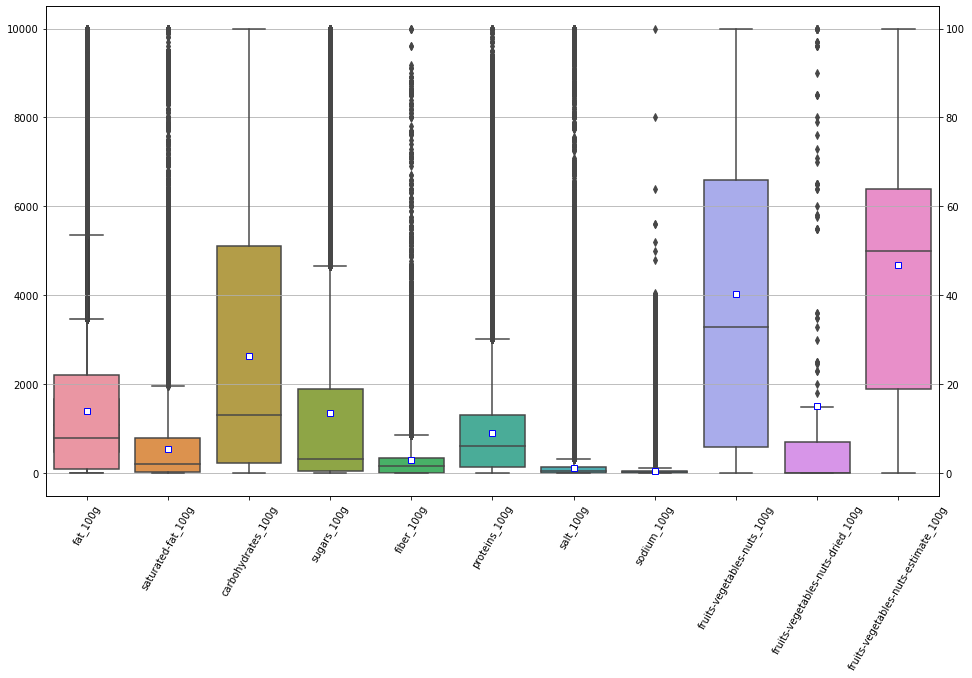

In [32]:
temp = raw_data.iloc[:,28]
temp2 = raw_data.iloc[:,29:40]

f, ax = plt.subplots(figsize=(16,9))
plt.xticks(rotation = 60)
ax2 = ax.twinx()

sns.boxplot(data=temp, dodge=False, orient = 'v', showfliers = True, showmeans = True,\
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"}, ax=ax)

sns.boxplot(data=temp2, dodge=False, orient = 'v', showfliers = True, showmeans = True,\
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"}, ax=ax2)


plt.grid()
plt.draw()

del temp, temp2

In [33]:
raw_data.columns[28:40]

Index(['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'fruits-vegetables-nuts_100g',
       'fruits-vegetables-nuts-dried_100g',
       'fruits-vegetables-nuts-estimate_100g'],
      dtype='object')

In [34]:
temp_raw = raw_data.loc[:, ['nutriscore_grade','energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'fruits-vegetables-nuts_100g',
       'fruits-vegetables-nuts-dried_100g',
       'fruits-vegetables-nuts-estimate_100g']]
temp_raw = temp_raw.melt(id_vars = 'nutriscore_grade',value_vars=temp_raw.columns[1:]).dropna()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


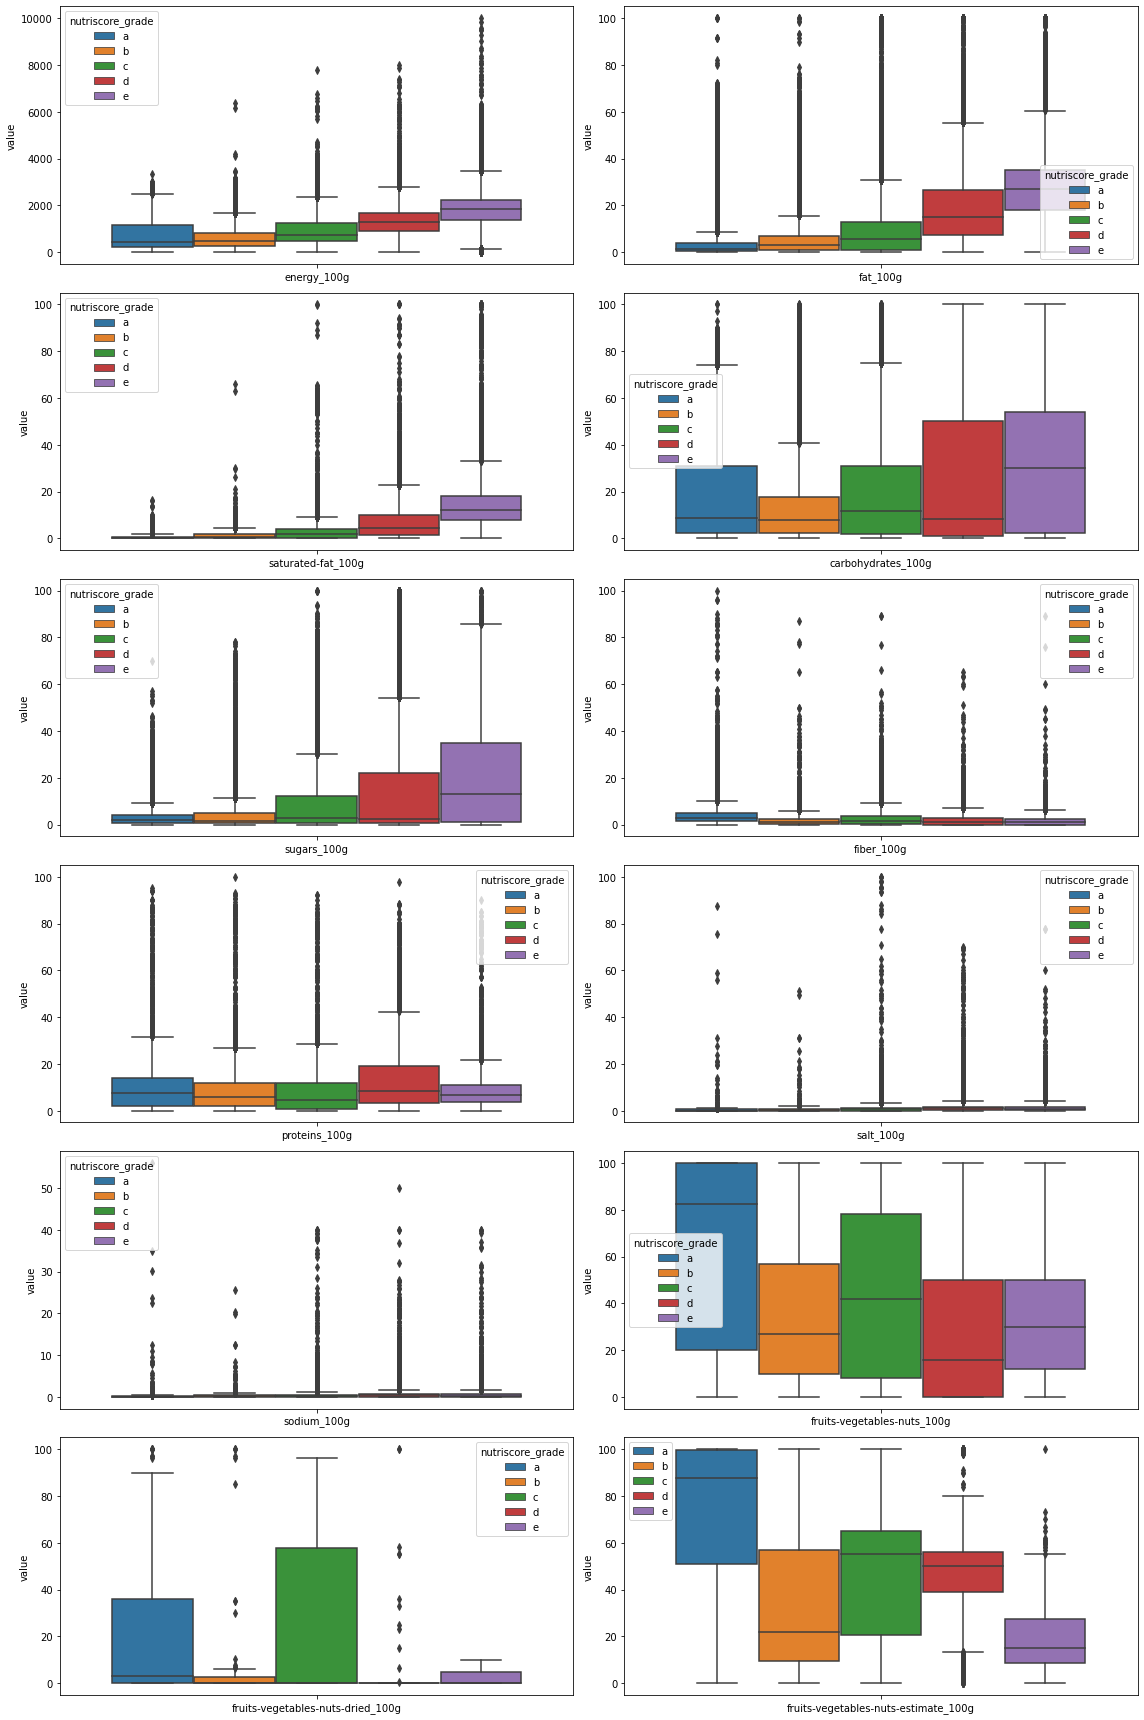

In [35]:
choices = raw_data.loc[:, ['nutriscore_grade','energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'fruits-vegetables-nuts_100g',
       'fruits-vegetables-nuts-dried_100g',
       'fruits-vegetables-nuts-estimate_100g']].columns

f, axs = plt.subplots(6,2, figsize = (16, 24))

i=1
choices[i]

for ix,iy in np.ndindex(axs.shape):
    sns.boxplot(data=temp_raw[temp_raw['variable']==choices[i]], x='variable', y='value', hue="nutriscore_grade",
                hue_order=["a","b","c","d","e"], ax=axs[ix,iy]).set(xlabel=None)
    
    plt.legend(loc = 'upper left')
    i+=1



plt.tight_layout()

del choices, temp_raw

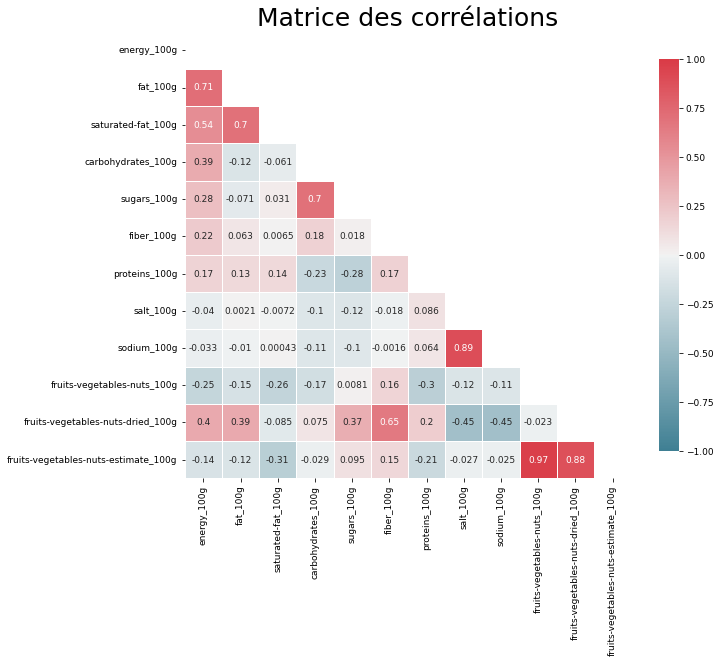

In [36]:
matrice_correlation = raw_data.iloc[:,28:40]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 9}

plt.rc('font', **font)

# Compute the correlation matrix
corr = matrice_correlation.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmin=-1,vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot = True, ax = ax).set_title("Matrice des corrélations", size = 25)

plt.draw()

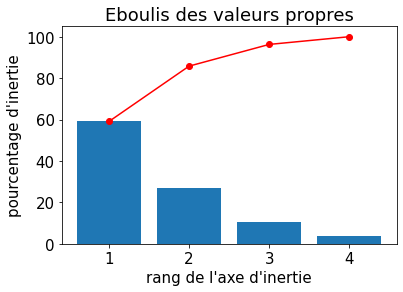

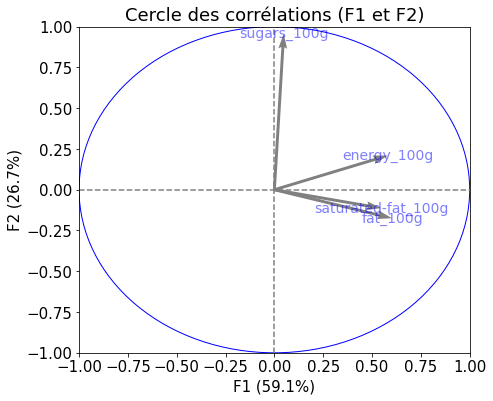

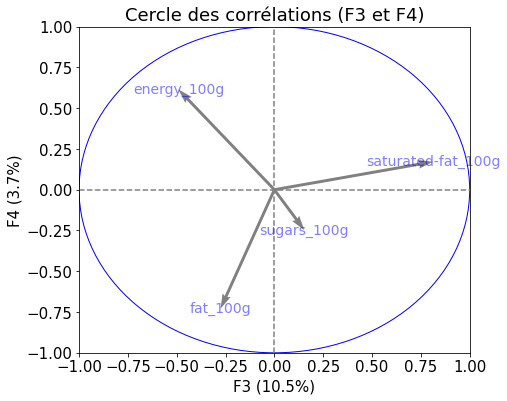

In [37]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

data = raw_data.loc[:,['nutriscore_grade', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g']].dropna(subset=["nutriscore_grade"])
data = data.loc[:,['energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g']]

# choix du nombre de composantes à calculer
n_comp = 4

# préparation des données pour l'ACP
data_pca = data.fillna(data.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = data_pca.index # ou data.index pour avoir les intitulés
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
#display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(names))

plt.show()

In [38]:
temp_ctr_cos2 = data.copy()

n = temp_ctr_cos2.shape[0]
p = temp_ctr_cos2.shape[1]
eigval = (n-1)/n*pca.explained_variance_


temp_ctr_cos2["Coord_C1"] = X_projected[:,0]
temp_ctr_cos2["Coord_C2"] = X_projected[:,1]
temp_ctr_cos2["Coord_C3"] = X_projected[:,2]
temp_ctr_cos2["Coord_C4"] = X_projected[:,3]
temp_ctr_cos2["CTR"] = np.sum(X_scaled**2, axis = 1)
temp_ctr_cos2["Cos2_1"] = round(((temp_ctr_cos2["Coord_C1"]**2)/temp_ctr_cos2["CTR"])*100,3)
temp_ctr_cos2["Cos2_2"] = round(((temp_ctr_cos2["Coord_C2"]**2)/temp_ctr_cos2["CTR"])*100,3)
temp_ctr_cos2["Cos2_3"] = round(((temp_ctr_cos2["Coord_C3"]**2)/temp_ctr_cos2["CTR"])*100,3)
temp_ctr_cos2["Cos2_4"] = round(((temp_ctr_cos2["Coord_C4"]**2)/temp_ctr_cos2["CTR"])*100,3)
temp_ctr_cos2["Cum_Cos2_1&2"] = round((temp_ctr_cos2["Cos2_1"]+temp_ctr_cos2["Cos2_2"]),3)
#temp_ctr_cos2["Cum_Cos2"] = temp_ctr_cos2["Cum_Cos2"].map(str) + "%"
#temp_ctr_cos2["Cos2_1"] = temp_ctr_cos2["Cos2_1"].map(str)+"%"
#temp_ctr_cos2["Cos2_2"] = temp_ctr_cos2["Cos2_2"].map(str)+"%"
#temp_ctr_cos2["Cos2_3"] = temp_ctr_cos2["Cos2_3"].map(str)+"%"
temp_ctr_cos2["CTR_1"] = (temp_ctr_cos2["Coord_C1"]**2)/(n*eigval[0])
temp_ctr_cos2["CTR_2"] = (temp_ctr_cos2["Coord_C2"]**2)/(n*eigval[1])
temp_ctr_cos2["CTR_3"] = (temp_ctr_cos2["Coord_C3"]**2)/(n*eigval[2])
temp_ctr_cos2["CTR_4"] = (temp_ctr_cos2["Coord_C4"]**2)/(n*eigval[3])


sqrt_eigval = np.sqrt(eigval)

corvar = np.zeros((p,p))
corr = np.zeros((p,p))
for k in range(4):
    corr[:,k] = pcs[k,:]
    corvar[:,k] = pcs[k,:] * sqrt_eigval[k]

cos2var = corvar**2
temp1 = pd.DataFrame({'id':data.columns,'CORR_1':corr[:,0],'CORR_2':corr[:,1],'CORR_3':corr[:,2], 'CORR_4':corr[:,3],
                      'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1],'COS2_3':cos2var[:,2], 'COS2_4':cos2var[:,3]})

ctrvar = cos2var

temp1["CTR_1"] = ctrvar[:,0]/eigval[0]
temp1["CTR_2"] = ctrvar[:,1]/eigval[1]
temp1["CTR_3"] = ctrvar[:,2]/eigval[2]
temp1["CTR_4"] = ctrvar[:,3]/eigval[3]

In [39]:
temp1

,id,CORR_1,CORR_2,CORR_3,CORR_4,COS2_1,COS2_2,COS2_3,COS2_4,CTR_1,CTR_2,CTR_3,CTR_4
0,energy_100g,0.580281,0.209377,-0.491216,0.614933,0.795623,0.046855,0.101224,0.056299,0.336726,0.043839,0.241293,0.378142
1,fat_100g,0.602054,-0.174736,-0.275551,-0.728746,0.856447,0.032633,0.031852,0.079068,0.362469,0.030533,0.075928,0.531071
2,saturated-fat_100g,0.546388,-0.113049,0.811955,0.171492,0.705395,0.013659,0.276567,0.004379,0.298540,0.012780,0.659270,0.029410
3,sugars_100g,0.047593,0.955431,0.153325,-0.247746,0.005352,0.975648,0.009862,0.009138,0.002265,0.912848,0.023509,0.061378


In [40]:
for i in raw_data.columns[28:38] :
    a = str(sp.normaltest(raw_data[i].dropna()))
    print("Normal test for " + i + " : " + a)

Normal test for energy_100g : NormaltestResult(statistic=91869.62749916302, pvalue=0.0)
Normal test for fat_100g : NormaltestResult(statistic=255378.26389882815, pvalue=0.0)
Normal test for saturated-fat_100g : NormaltestResult(statistic=416903.16454852896, pvalue=0.0)
Normal test for carbohydrates_100g : NormaltestResult(statistic=87524.0206759588, pvalue=0.0)
Normal test for sugars_100g : NormaltestResult(statistic=187803.4255161757, pvalue=0.0)
Normal test for fiber_100g : NormaltestResult(statistic=142811.65414934422, pvalue=0.0)
Normal test for proteins_100g : NormaltestResult(statistic=338229.0967076426, pvalue=0.0)
Normal test for salt_100g : NormaltestResult(statistic=1119213.7329386962, pvalue=0.0)
Normal test for sodium_100g : NormaltestResult(statistic=1105174.6926885073, pvalue=0.0)
Normal test for fruits-vegetables-nuts_100g : NormaltestResult(statistic=4027.7104785105885, pvalue=0.0)


In [41]:
labelencoder = LabelEncoder()

In [42]:
for i in raw_data.columns[28:38] :
    a = str(sp.levene(raw_data.dropna(subset=[i, "nutriscore_grade"])[i], labelencoder.fit_transform(raw_data.dropna(subset=[i, "nutriscore_grade"])["nutriscore_grade"])))
    print("Levene test for " + i + ":" + a)

Levene test for energy_100g:LeveneResult(statistic=424836.8976445814, pvalue=0.0)
Levene test for fat_100g:LeveneResult(statistic=156148.92337930357, pvalue=0.0)
Levene test for saturated-fat_100g:LeveneResult(statistic=75960.48459166913, pvalue=0.0)
Levene test for carbohydrates_100g:LeveneResult(statistic=228392.61827843057, pvalue=0.0)
Levene test for sugars_100g:LeveneResult(statistic=85237.62960230175, pvalue=0.0)
Levene test for fiber_100g:LeveneResult(statistic=6913.025195869271, pvalue=0.0)
Levene test for proteins_100g:LeveneResult(statistic=183880.07401523425, pvalue=0.0)
Levene test for salt_100g:LeveneResult(statistic=2183.1140612443924, pvalue=0.0)
Levene test for sodium_100g:LeveneResult(statistic=77516.00497563524, pvalue=0.0)
Levene test for fruits-vegetables-nuts_100g:LeveneResult(statistic=11303.990900288441, pvalue=0.0)


In [80]:
anova_list = ["fat_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g", "sodium_100g"]

model = ols('fat_100g ~ C(nutriscore_grade)', data=raw_data).fit()
print("fat_100g : " + str(sm.stats.anova_lm(model, typ=2)))

model = ols('sugars_100g ~ C(nutriscore_grade)', data=raw_data).fit()
print("sugars_100g : " + str(sm.stats.anova_lm(model, typ=2)))

model = ols('fiber_100g ~ C(nutriscore_grade)', data=raw_data).fit()
print("fiber_100g : " + str(sm.stats.anova_lm(model, typ=2)))

model = ols('proteins_100g ~ C(nutriscore_grade)', data=raw_data).fit()
print("proteins_100g : " + str(sm.stats.anova_lm(model, typ=2)))

model = ols('salt_100g ~ C(nutriscore_grade)', data=raw_data).fit()
print("salt_100g : " + str(sm.stats.anova_lm(model, typ=2)))

model = ols('sodium_100g ~ C(nutriscore_grade)', data=raw_data).fit()
print("sodium_100g : " + str(sm.stats.anova_lm(model, typ=2)))

fat_100g :                            sum_sq        df             F  PR(>F)
C(nutriscore_grade)  1.601855e+07       4.0  13816.803495     0.0
Residual             7.369225e+07  254253.0           NaN     NaN
sugars_100g :                            sum_sq        df            F  PR(>F)
C(nutriscore_grade)  8.444097e+06       4.0  7078.597848     0.0
Residual             7.582494e+07  254253.0          NaN     NaN
fiber_100g :                            sum_sq       df           F  PR(>F)
C(nutriscore_grade)  7.560660e+04      4.0  1101.27847     0.0
Residual             1.437793e+06  83771.0         NaN     NaN
proteins_100g :                            sum_sq        df            F  PR(>F)
C(nutriscore_grade)  5.778798e+05       4.0  1790.809703     0.0
Residual             2.051159e+07  254256.0          NaN     NaN
salt_100g :                             sum_sq        df            F  PR(>F)
C(nutriscore_grade)   47410.979758       4.0  3052.897788     0.0
Residual             9873